<a href="https://colab.research.google.com/github/junsookim76/ChemML/blob/main/MP_QSAR_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -q
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local &>/dev/null
!conda install -q -y -c rdkit rdkit python=3.7
!pip install -q mordred seaborn
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
IPythonConsole.ipython_useSVG=True

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - python=3.7
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bottleneck-1.3.2           |   py37heb32a55_1         125 KB
    brotlipy-0.7.0             |py37h27cfd23_1003         320 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2021.10.26 |       h06a4308_2         115 KB
    cairo-1.16.0               |       hf32fb01_1         1.0 MB
    certifi-2021.10.8          |   py37h06a4308_0         151 KB
    cffi-1.14.6                |   py37h400218f_0         223 KB
    chardet-4.0.0              |py37h06a4308_1003         195 KB
    conda-4.10.3               |   py37h06a4308_0         2.9 MB
    conda-package-handling-1.7.3|   py37h27cfd23_1   

# Reading Database

In [2]:
!wget https://raw.githubusercontent.com/junsookim76/ChemML/main/mpn.csv

--2021-11-29 07:32:58--  https://raw.githubusercontent.com/junsookim76/ChemML/main/mpn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 675712 (660K) [text/plain]
Saving to: ‘mpn.csv’

mpn.csv             100%[===================>] 659.88K  --.-KB/s    in 0.04s   

2021-11-29 07:32:58 (14.8 MB/s) - ‘mpn.csv’ saved [675712/675712]



In [3]:
mols=[]

csv_file_name = "mpn.csv"
sample_data = pd.read_csv(csv_file_name)

mpn=sample_data.iloc[:,1:]

print(mpn.shape)

print(mpn)

for _,i in mpn.iterrows():
    mol=Chem.MolFromSmiles(i["SMILES"])
    mols.append(mol)


(14897, 2)
                                                  SMILES  Melting Point
0      CN(C1=CC2=NC3=C(C=CC4=C3COCN4)C=C2C=C1)S(C)(=O)=O          300.0
1        CNC1=CC=C2C=C3C=CC(=CC3=NC2=C1CO)N(C)S(C)(=O)=O          150.0
2      CCOC(=O)NC1=CC2=NC3=C(C=CC4=C3COCN4C(=O)OCC)C=...          174.0
3       CCOC(=O)NC1=CC=C2C=C3C=CC4=C(COC(=O)N4)C3=NC2=C1          235.0
4            CCOC(=O)NC1=CC2=NC3=C(C=CC(N)=C3CO)C=C2C=C1          135.0
...                                                  ...            ...
14892                                CC(C)=CCC\C(C)=C/CO           50.0
14893  COC1=CC(OC)=NC(NC(=O)NS(=O)(=O)C2=C(C(O)=O)C(C...          176.0
14894             CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C(Cl)=N1          150.5
14895  C[C@]12C=CC3=C4CCC(=O)C=C4CC[C@H]3[C@@H]1CC[C@...           93.0
14896  CCCCCCCCCCCCS[C@H](C(=O)NC1=C(C)C(C)=C(O)C(C)=...          130.0

[14897 rows x 2 columns]


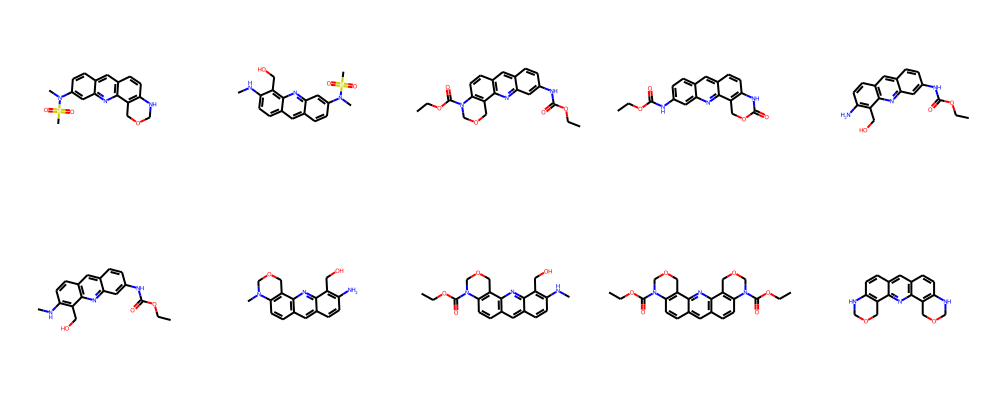

In [6]:
Draw.MolsToGridImage(mols[:10],molsPerRow=5)

# Calculation of Mordred Descriptors

In [7]:
n_all = len(Calculator(descriptors, ignore_3D=False).descriptors)
n_2D = len(Calculator(descriptors, ignore_3D=True).descriptors)
print("2D:    {:5}\n3D:    {:5}\n------------\ntotal: {:5}".format(n_2D, n_all - n_2D, n_all))

2D:     1613
3D:      213
------------
total:  1826


In [8]:
calc=Calculator(descriptors.ABCIndex)

In [9]:
calc.register(descriptors.AcidBase)
calc.register(descriptors.Aromatic)
calc.register(descriptors.AtomCount)
calc.register(descriptors.BondCount)
calc.register(descriptors.BalabanJ)
calc.register(descriptors.HydrogenBond)
calc.register(descriptors.Polarizability)
calc.register(descriptors.WalkCount)
calc.register(descriptors.Weight)
calc.register(descriptors.TopologicalCharge)
calc.register(descriptors.Constitutional)
print(len(calc.descriptors))

97


In [10]:
mordred=calc.pandas(mols)

100%|██████████| 14897/14897 [05:03<00:00, 49.14it/s]


In [11]:
mordred

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,nBonds,nBondsO,nBondsS,nBondsD,nBondsT,nBondsA,nBondsM,nBondsKS,nBondsKD,BalabanJ,nHBAcc,nHBDon,apol,bpol,MWC01,MWC02,MWC03,...,TSRW10,MW,AMW,GGI1,GGI2,GGI3,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,GGI10,JGI1,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,SZ,Sm,Sv,Sse,Spe,Sare,Sp,Si,MZ,Mm,Mv,Mse,Mpe,Mare,Mp,Mi
0,19.414219,14.458738,0,0,14,16,41,24,0,0,7,17,0,17,3,3,1,0,0,0,0,0,0,44,27,26,2,0,16,18,35,9,1.443984,5,1,48.331481,28.866519,27.0,4.919981,5.796058,...,59.390224,343.099062,8.368270,6.0,3.555556,1.687500,1.844444,0.750000,0.605714,0.368056,0.340892,0.214375,0.111417,0.222222,0.086721,0.039244,0.051235,0.024194,0.023297,0.016730,0.017942,0.012610,0.010129,0.504323,30.000000,28.590542,27.210879,41.604880,40.301961,40.820,28.941007,45.950382,0.731707,0.697330,0.663680,1.014753,0.982975,0.995610,0.705878,1.120741
1,18.707112,14.984016,0,0,14,16,43,24,0,0,7,19,0,17,3,3,1,0,0,0,0,0,0,45,26,27,2,0,16,18,36,9,1.686200,5,2,49.665067,29.136933,26.0,4.875197,5.746203,...,59.128229,345.114712,8.025924,6.5,3.777778,1.937500,2.062222,0.923611,0.687347,0.430556,0.390275,0.245625,0.086624,0.250000,0.096866,0.045058,0.054269,0.028863,0.026436,0.019571,0.020541,0.014449,0.007875,0.563927,30.333333,28.758388,27.752707,43.492717,42.027451,42.580,29.739561,48.365672,0.705426,0.668800,0.645412,1.011459,0.977383,0.990233,0.691618,1.124783
2,22.603556,16.412053,0,0,14,16,50,29,0,0,8,21,0,21,3,5,0,0,0,0,0,0,0,53,32,35,2,0,16,18,44,9,1.391574,6,1,56.382653,31.431347,32.0,5.043425,5.910797,...,64.816581,395.148121,7.902962,5.5,3.333333,2.125000,1.955556,0.930556,0.746939,0.460069,0.352734,0.225625,0.160902,0.171875,0.074074,0.042500,0.040741,0.021641,0.019656,0.013941,0.012598,0.009025,0.007662,0.413713,34.666667,32.921072,32.537078,50.965040,49.439216,50.164,33.762068,56.279686,0.693333,0.658421,0.650742,1.019301,0.988784,1.003280,0.675241,1.125594
3,19.856009,14.269577,0,0,14,16,40,25,0,0,7,15,0,18,3,4,0,0,0,0,0,0,0,43,28,25,2,0,16,18,34,9,1.371348,5,2,46.569895,22.536105,28.0,4.919981,5.783825,...,60.200023,337.106256,8.427656,5.5,2.666667,1.625000,1.835556,0.631944,0.604082,0.314236,0.270093,0.185625,0.103051,0.196429,0.066667,0.038690,0.049610,0.019748,0.021574,0.013093,0.013505,0.010919,0.007361,0.437596,29.333333,28.085505,27.196796,40.970867,39.913725,40.484,27.886165,44.824431,0.733333,0.702138,0.679920,1.024272,0.997843,1.012100,0.697154,1.120611
4,17.734689,13.782162,0,0,14,16,40,23,0,0,6,17,0,17,3,3,0,0,0,0,0,0,0,42,25,25,1,0,16,17,34,8,1.590909,5,3,45.431481,20.798519,25.0,4.795791,5.652489,...,57.515601,311.126991,7.778175,5.0,2.666667,1.687500,1.662222,0.659722,0.545306,0.302083,0.245906,0.150000,0.078359,0.200000,0.076190,0.044408,0.048889,0.023562,0.022721,0.015104,0.015369,0.011538,0.007124,0.464905,27.333333,25.921322,26.023824,40.528041,39.290196,39.844,27.204480,45.030335,0.683333,0.648033,0.650596,1.013201,0.982255,0.996100,0.680112,1.125758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892,7.399237,7.388977,0,0,0,0,29,11,0,0,1,18,0,10,0,1,0,0,0,0,0,0,0,28,10,26,2,0,0,2,26,2,3.099621,1,1,29.504274,18.057726,10.0,3.761200,4.418841,...,38.565088,154.135765,5.315026,2.5,0.888889,0.500000,0.160000,0.222222,0.081633,0.062500,0.000000,0.000000,0.000000,0.250000,0.080808,0.055556,0.020000,0.037037,0.013605,0.020833,0.000000,0.000000,0.000000,0.477839,14.333333,12.842644,15.591249,28.321194,26.878431,27.240,17.667230,32.946993,0.494253,0.442850,0.537629,0.976593,0.926842,0.939310,0.609215,1.136103
14893,20.440406,18.308961,1,0,11,11,40,27,0,0,15,13,0,12,6,7,1,0,0,1,0,0,1,41,28,26,4,0,11,15,32,9,1.993282,10,3,46.002309,30.545691,28.0,4.9

# Multi Linear Perceptron Regressor

In [12]:
MLP=make_pipeline(QuantileTransformer(),
                MLPRegressor(hidden_layer_sizes=(100, 50, 100),
                             learning_rate_init=0.01,
                             max_iter=500,
                             early_stopping=True),
                             verbose=True)

In [13]:
X=mordred
y=mpn.iloc[:,1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7)

In [15]:
MLP.fit(X_train, y_train)

[Pipeline]  (step 1 of 2) Processing quantiletransformer, total=   0.3s
[Pipeline] ...... (step 2 of 2) Processing mlpregressor, total=  12.1s


Pipeline(steps=[('quantiletransformer', QuantileTransformer()),
                ('mlpregressor',
                 MLPRegressor(early_stopping=True,
                              hidden_layer_sizes=(100, 50, 100),
                              learning_rate_init=0.01, max_iter=500))],
         verbose=True)

Text(0, 0.5, 'Actual Y')

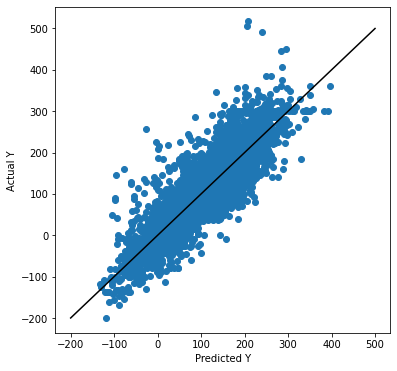

In [17]:
x = [-200, 50, 500]
y = [-200, 50, 500]

fig=plt.figure(figsize=(6,6))
plt.plot(MLP.predict(X_test),y_test,"o")
plt.plot(x,y, 'k-')
plt.xlabel("Predicted Y")
plt.ylabel("Actual Y")


In [18]:
from sklearn.metrics import mean_squared_error
Squared = False
RMSE_train = mean_squared_error(y_train,MLP.predict(X_train))**0.5
RMSE = mean_squared_error(y_test,MLP.predict(X_test))**0.5

from sklearn.metrics import r2_score
R2 = r2_score(y_test,MLP.predict(X_test))

print ("RMSE(train) : %.6f" % RMSE_train)
print ("RMSE(test) : %.6f" % RMSE)
print ("R^2 : %.6f" % R2)


RMSE(train) : 43.250314
RMSE(test) : 47.926592
R^2 : 0.720066
